### Volkswagen Data Time Series Analysis

In [3]:
# importing packages

import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace import sarimax
from pmdarima.arima import auto_arima
from pmdarima.arima import OCSBTest
from arch import arch_model
import seaborn as sns
import yfinance
import warnings
warnings.filterwarnings("ignore")
sns.set()

In [4]:
# importing data

raw_data = yfinance.download(tickers= "VOW3.DE, PAH3.DE, BMW.DE", interval='1d',group_by='ticker',
                             auto_adjust= True, threads=True)

[*********************100%***********************]  3 of 3 completed


In [5]:
df = raw_data.copy()
df.tail()

Ticker        PAH3.DE                                                BMW.DE  \
Price            Open       High        Low      Close    Volume       Open   
Date                                                                          
2025-05-13  37.500000  38.230000  37.459999  38.090000  734901.0  82.400002   
2025-05-14  38.090000  38.090000  38.090000  38.090000       0.0  83.980003   
2025-05-15  38.029999  38.419998  37.840000  37.980000  656601.0  78.099998   
2025-05-16  37.980000  37.980000  37.980000  37.980000       0.0  77.680000   
2025-05-19  37.990002  38.299999  37.040001  37.290001  787877.0  76.699997   

Ticker                                                  VOW3.DE             \
Price            High        Low      Close   Volume       Open       High   
Date                                                                         
2025-05-13  83.980003  81.900002  83.980003  1510091  96.302367  98.460136   
2025-05-14  83.980003  83.980003  83.980003        0  98.460136  98.460136   
2025-05-15  78.919998  77.160004  77.580002  1229215  96.771449  97.662701   
2025-05-16  78.180000  76.660004  76.919998  1029744  97.568886  98.131782   
2025-05-19  77.720001  76.699997  77.559998   579046  97.000000  98.620003   

Ticker                                       
Price             Low      Close     Volume  
Date                                         
2025-05-13  95.880190  98.460136  1317113.0  
2025-05-14  98.460136  98.460136        0.0  
2025-05-15  96.536909  97.381256   798333.0  
2025-05-16  95.833287  96.489998  1518948.0  
2025-05-19  96.800003  97.500000  1444026.0

In [6]:
# Defining Key Dates

# starting date
start_date = '2009-04-05'

# first official announcement 49.9%
ann_1 = '2009-12-09'

# second official announcement 50.1
ann_2 = '2012-07-05'

#ending date
end_date = '2014-01-01'

# dieselgate
d_gate = '2015-09-20'

#### Data Preprocessing

In [7]:
# extracting closing prices

df['vol'] = df['VOW3.DE'].Close
df['por'] = df['PAH3.DE'].Close
df['bmw'] = df['BMW.DE'].Close

# creating returns

df['ret_vol'] = df['vol'].pct_change(1).mul(100)
df['ret_por'] = df['por'].pct_change(1).mul(100)
df['ret_bmw'] = df['bmw'].pct_change(1).mul(100)

# creating squared returns

df['sq_vol'] = df.ret_vol.mul(df.ret_vol)
df['sq_por'] = df.ret_por.mul(df.ret_por)
df['sq_bmw'] = df.ret_bmw.mul(df.ret_bmw)

# extracting volume

df['q_vol'] = df['VOW3.DE'].Volume
df['q_por'] = df['PAH3.DE'].Volume
df['q_bmw'] = df['BMW.DE'].Volume

In [8]:
# assigning frequency and the fill missing data

df = df.asfreq('b')
df = df.fillna(method='ffill')

In [9]:
# removing surplus data

del df['VOW3.DE']
del df['PAH3.DE']
del df['BMW.DE']

df.tail()

Ticker,vol,por,bmw,ret_vol,ret_por,ret_bmw,sq_vol,sq_por,sq_bmw,q_vol,q_por,q_bmw
Price,,,,,,,,,,,,
Date,,,,,,,,,,,,
2025-05-13,98.460136,38.090000,83.980003,3.756789,2.117965,3.017673,14.113467,4.485776,9.106349,1317113.0,734901.0,1510091.0
2025-05-14,98.460136,38.090000,83.980003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2025-05-15,97.381256,37.980000,77.580002,-1.095753,-0.288791,-7.620864,1.200676,0.083400,58.077562,798333.0,656601.0,1229215.0
2025-05-16,96.489998,37.980000,76.919998,-0.915226,0.000000,-0.850739,0.837638,0.000000,0.723758,1518948.0,0.0,1029744.0
2025-05-19,97.500000,37.290001,77.559998,1.046743,-1.816742,0.832033,1.095671,3.300552,0.692278,1444026.0,787877.0,579046.0


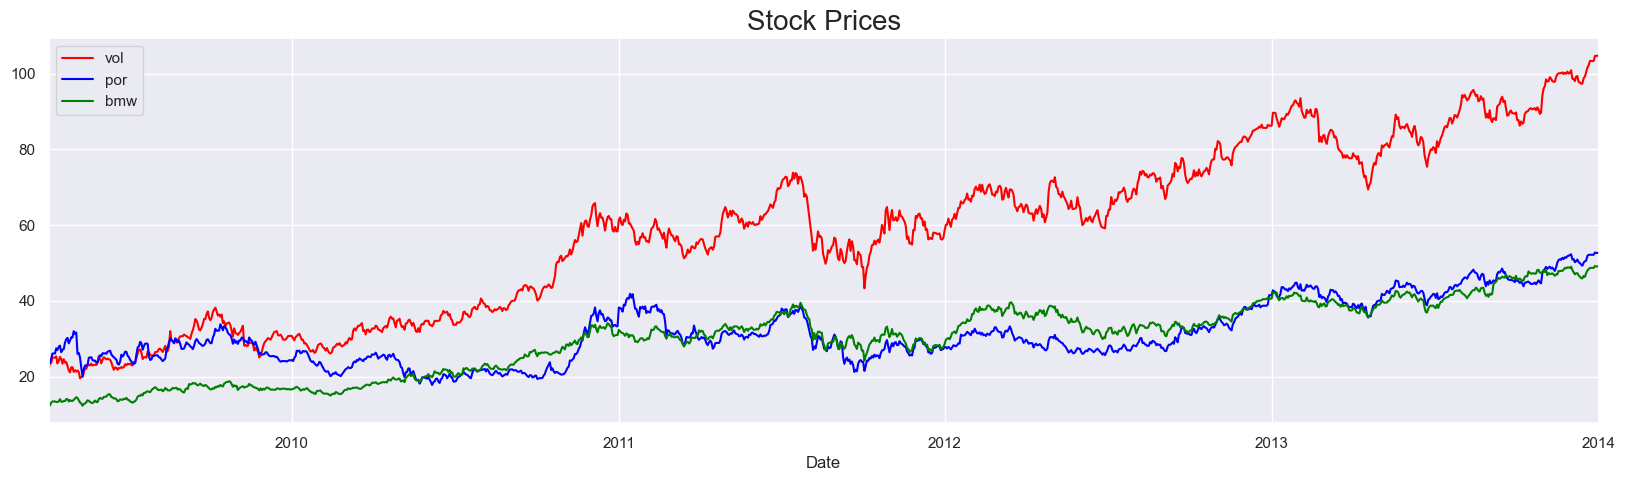

In [10]:
# plotting stock price data

df['vol'][start_date:end_date].plot(figsize=(20,5),color = 'red')
df['por'][start_date:end_date].plot(color = 'blue')
df['bmw'][start_date:end_date].plot(color = 'green')
plt.title('Stock Prices', size=20)
plt.legend()
plt.show()

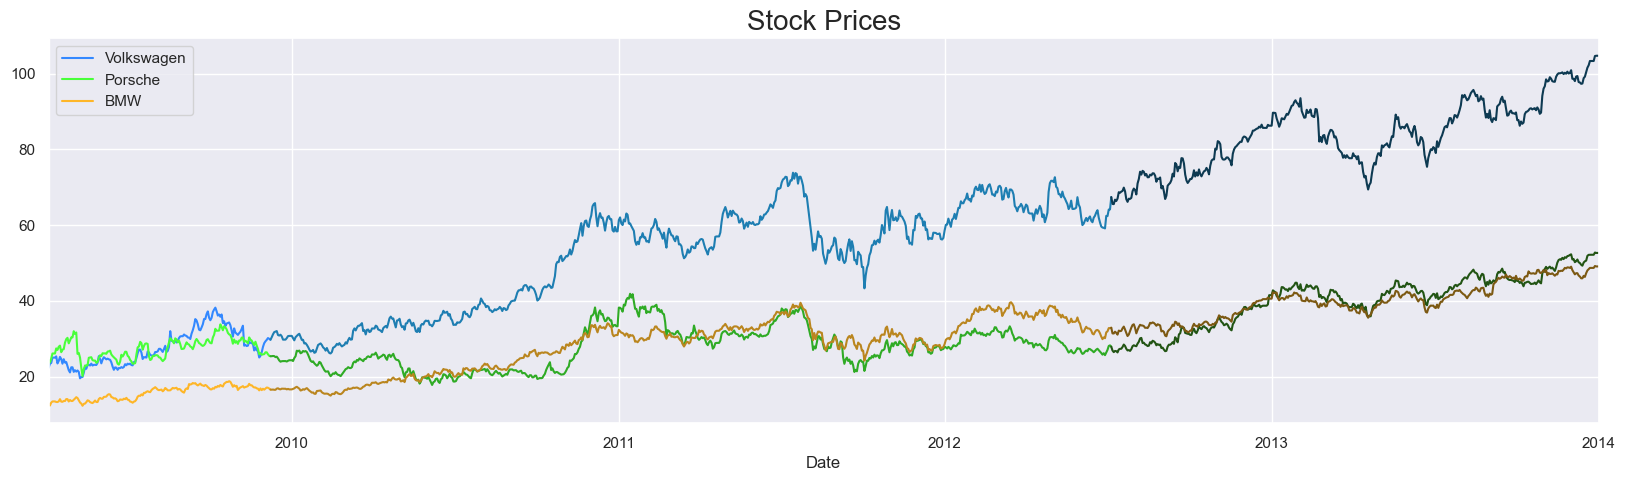

In [12]:
# plotting different intervals with different shades of colours to have a better idea

df['vol'][start_date:ann_1].plot(figsize=(20,5),color = '#3388FF')
df['por'][start_date:ann_1].plot(color = '#49FF3A')
df['bmw'][start_date:ann_1].plot(color = '#FEB628')

df['vol'][ann_1:ann_2].plot(color = '#1E7EB2')
df['por'][ann_1:ann_2].plot(color = '#2FAB25')
df['bmw'][ann_1:ann_2].plot(color = '#BA861F')

df['vol'][ann_2:end_date].plot(color = '#0E3A52')
df['por'][ann_2:end_date].plot(color = '#225414')
df['bmw'][ann_2:end_date].plot(color = '#7C5913')

plt.title('Stock Prices', size=20)
plt.legend(['Volkswagen','Porsche','BMW'])
plt.show()

#### Correlation

In [14]:
print ('Correlation among manufacturers from ' + str(start_date) + ' to ' + str(end_date) +'\n')
print('Volkswagen and Porsche Correlation: \t' + str(df['vol'][start_date:end_date].corr(df['por'][start_date:end_date])))
print('Volkswagen and BMW Correlation: \t' + str(df['vol'][start_date:end_date].corr(df['bmw'][start_date:end_date])))
print('Porsche and BMW Correlation: \t' + str(df['por'][start_date:end_date].corr(df['bmw'][start_date:end_date])))

Correlation among manufacturers from 2009-04-05 to 2014-01-01

Volkswagen and Porsche Correlation: 	0.8364635056030901
Volkswagen and BMW Correlation: 	0.9798969089579328
Porsche and BMW Correlation: 	0.8057254282712748


In [15]:
print ('Correlation among manufacturers from ' + str(start_date) + ' to ' + str(ann_1) +'\n')
print('Volkswagen and Porsche Correlation: \t' + str(df['vol'][start_date:ann_1].corr(df['por'][start_date:ann_1])))
print('Volkswagen and BMW Correlation: \t' + str(df['vol'][start_date:ann_1].corr(df['bmw'][start_date:ann_1])))
print('Porsche and BMW Correlation: \t' + str(df['por'][start_date:ann_1].corr(df['bmw'][start_date:ann_1])))

Correlation among manufacturers from 2009-04-05 to 2009-12-09

Volkswagen and Porsche Correlation: 	0.6762283063620201
Volkswagen and BMW Correlation: 	0.8441703734333013
Porsche and BMW Correlation: 	0.6217077837339718


This suggests that the stock prices for these brands weren't too similar before the start of the buyout.

In [17]:
print ('Correlation among manufacturers from ' + str(ann_1) + ' to ' + str(ann_2) +'\n')
print('Volkswagen and Porsche Correlation: \t' + str(df['vol'][ann_1:ann_2].corr(df['por'][ann_1:ann_2])))
print('Volkswagen and BMW Correlation: \t' + str(df['vol'][ann_1:ann_2].corr(df['bmw'][ann_1:ann_2])))
print('Porsche and BMW Correlation: \t' + str(df['por'][ann_1:ann_2].corr(df['bmw'][ann_1:ann_2])))

Correlation among manufacturers from 2009-12-09 to 2012-07-05

Volkswagen and Porsche Correlation: 	0.7434173033595164
Volkswagen and BMW Correlation: 	0.9795878032011145
Porsche and BMW Correlation: 	0.7051170714850444


In [18]:
print ('Correlation among manufacturers from ' + str(ann_2) + ' to ' + str(end_date) +'\n')
print('Volkswagen and Porsche Correlation: \t' + str(df['vol'][ann_2:end_date].corr(df['por'][ann_2:end_date])))
print('Volkswagen and BMW Correlation: \t' + str(df['vol'][ann_2:end_date].corr(df['bmw'][ann_2:end_date])))
print('Porsche and BMW Correlation: \t' + str(df['por'][ann_2:end_date].corr(df['bmw'][ann_2:end_date])))

Correlation among manufacturers from 2012-07-05 to 2014-01-01

Volkswagen and Porsche Correlation: 	0.94096089385257
Volkswagen and BMW Correlation: 	0.9291130890896648
Porsche and BMW Correlation: 	0.9497199992902036


In [19]:
print ('Correlation among manufacturers from ' + str(end_date) + ' to ' + str(df.index[-1]) +'\n')
print('Volkswagen and Porsche Correlation: \t' + str(df['vol'][end_date:].corr(df['por'][end_date:])))
print('Volkswagen and BMW Correlation: \t' + str(df['vol'][end_date:].corr(df['bmw'][end_date:])))
print('Porsche and BMW Correlation: \t' + str(df['por'][end_date:].corr(df['bmw'][end_date:])))

Correlation among manufacturers from 2014-01-01 to 2025-05-19 00:00:00

Volkswagen and Porsche Correlation: 	0.8368617761349737
Volkswagen and BMW Correlation: 	0.48254873729377373
Porsche and BMW Correlation: 	0.20928374569623992
